<p style ='text-align:right;'> Author @Nikesh Bajaj</p>
<p style ='text-align:right;'><a>https://github.com/nikeshbajaj</a></p>
<p style ='text-align:right;'><a>http://nikeshbajaj.in</a> </p>

<div align="center"> 
<h1> Custom Frequency Bands for Feature Extraction</h1> 
<h1> Feature Engineering</h1> 
</div>

In this notebook, we demonstrate, how we can extract Rhythmic features from EEG with custom frequency bands and more than just sum of power in a band, we will be extracting mean power, and standard deviation of power in a frequency band. We also exploint the feature of normializing, avoid using log-power and flattening the features.

We will be again focusing on a single task

<div align="right"> 
<table><tr>
<td></td>
<td>
<p style="text-align:right; font-weight:bold;"><br><a class="reference external image-reference" href="https://nbviewer.org/github/Nikeshbajaj/Notebooks/blob/master/PhyAAt_Notebooks/Example8_Custom_Freq_Bands.ipynb" target="_blank"><img src="https://raw.githubusercontent.com/spkit/spkit.github.io/master/assets/images/nav_logo.svg" width="150px"></a></p></td><td>
<p style="text-align:right; font-weight:bold;">Execute with <br><a class="reference external image-reference" href="https://mybinder.org/v2/gh/Nikeshbajaj/Notebooks/master?filepath=PhyAAt_Notebooks/Example8_Custom_Freq_Bands.ipynb.ipynb" target="_blank"><img src="https://mybinder.org/badge_logo.svg" width="150px"></a></p>
</td></tr></table>
</div>

<table style='center'>
<tr>
<td><img src="https://phyaat.github.io/modeling/figures/atar_7_0.png" alt="drawing" width="500"/></td>
 
<td>
<table style='center'>
<tr><td><img src="https://phyaat.github.io/modeling/figures/FE_8_2.png" alt="drawing" width="700"/></td></tr>
<tr><td><img src="https://phyaat.github.io/modeling/figures/FE_8_3.png" alt="drawing" width="700"/></td>
</tr></table>
<td>
</tr></table>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-and-Load-a-subject's-data" data-toc-modified-id="Download-and-Load-a-subject's-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download and Load a subject's data</a></span></li><li><span><a href="#Pre-processing:-high-pass-&amp;-ATAR" data-toc-modified-id="Pre-processing:-high-pass-&amp;-ATAR-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-processing: high-pass &amp; ATAR</a></span></li><li><span><a href="#T3-Task:-Semanticity-Prediction" data-toc-modified-id="T3-Task:-Semanticity-Prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>T3 Task: Semanticity Prediction</a></span></li><li><span><a href="#Feature-Extraction" data-toc-modified-id="Feature-Extraction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Extraction</a></span><ul class="toc-item"><li><span><a href="#Extract-default-power-of-6-freq-bands-and-flat-as-1D-vector-(default-setting)" data-toc-modified-id="Extract-default-power-of-6-freq-bands-and-flat-as-1D-vector-(default-setting)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Extract default power of 6-freq bands and flat as 1D vector (default setting)</a></span></li><li><span><a href="#No-flattening---2D-Tensor" data-toc-modified-id="No-flattening---2D-Tensor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>No-flattening - 2D-Tensor</a></span></li><li><span><a href="#No-log10+1" data-toc-modified-id="No-log10+1-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>No log10+1</a></span></li><li><span><a href="#Spatial-normalization-(For-each-band-normalize-over-channels)" data-toc-modified-id="Spatial-normalization-(For-each-band-normalize-over-channels)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Spatial normalization (For each band normalize over channels)</a></span></li></ul></li><li><span><a href="#Custom-Frequency-Bands" data-toc-modified-id="Custom-Frequency-Bands-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Custom Frequency Bands</a></span></li><li><span><a href="#More-than-Sum-of-Power" data-toc-modified-id="More-than-Sum-of-Power-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>More than Sum of Power</a></span></li><li><span><a href="#Documentation" data-toc-modified-id="Documentation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Documentation</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#!pip install phyaat  # if not installed yet

import phyaat as ph
print('Version :' ,ph.__version__)

Version : 0.0.3


## Download and Load a subject's data

In [6]:
# Download dataset of one subject only (subject=10)
# To download data of all the subjects use subject =-1 or for specify for one e.g.subject=10

dirPath = ph.download_data(baseDir='../PhyAAt/data/', subject=10,verbose=0,overwrite=False)

baseDir='../PhyAAt/data/' # or dirPath return path from above

#returns a dictionary containing file names of all the subjects available in baseDir
SubID = ph.ReadFilesPath(baseDir) 

#check files of subject=1
print(SubID[10])

# Create a Subj holding dataset of subject=1

Subj = ph.Subject(SubID[10])

Total Subjects :  3
{'sigFile': '../PhyAAt/data/phyaat_dataset/Signals/S10/S10_Signals.csv', 'txtFile': '../PhyAAt/data/phyaat_dataset/Signals/S10/S10_Textscore.csv'}


## Pre-processing: high-pass & ATAR

WPD Artifact Removal
WPD: True  Wavelet: db3 , Method: ipr , OptMode: elim
IPR= [25, 75] , Beta: 0.1 , [k1,k2]= [10, 100]
Reconstruction Method: custom , Window: ['hamming', True] , (Win,Overlap)= (640, 320)



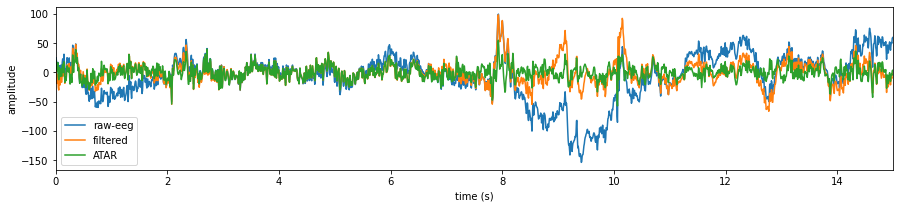

In [8]:
#filtering with highpass filter of cutoff frequency 0.5Hz and lowpass with 24 Hz (no reason why)

Subj.filter_EEG(band =[0.5],btype='highpass',method='SOS',order=5)

ch_names = list(Subj.rawData['D'])[1:15]
fs=128

# Let's check the signals

X0 = Subj.getEEG(useRaw=True).to_numpy()[fs*20:fs*35,1]
X1 = Subj.getEEG(useRaw=False).to_numpy()[fs*20:fs*35,1]
t = np.arange(len(X0))/fs

plt.figure(figsize=(15,3))
plt.plot(t,X0,label='raw-eeg')
plt.plot(t,X1,label='filtered')


#Remving Artifact using ATAR, setting window size to 128*5 (5 sec), which is larg, but takes less time
Subj.correct(method='ATAR',verbose=1,winsize=128*5,
            wv='db3',thr_method='ipr',IPR=[25,75],beta=0.1,k1=10,k2 =100,est_wmax=100,
            OptMode ='elim',fs=128.0,use_joblib=False)


X1 = Subj.getEEG().to_numpy()[fs*20:fs*35,1]
plt.plot(t,X1,label='ATAR')
plt.xlim([t[0],t[-1]])
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend()
plt.show()

## T3 Task: Semanticity Prediction

## Feature Extraction

### Extract default power of 6-freq bands and flat as 1D vector (default setting)

* **by default six frequency bands are used**
* **delta (<=4), theta (4-8), alpha (8-14), beta (14,30), Gamma_low (30,47), Gamma_high (47<=)**

In [77]:
fband_names = [r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$', r'$\gamma_{l}$', r'$\gamma_h$']

In [97]:
X_train,y_train,X_test,y_test = Subj.getXy_eeg(task=3,redo=True,normalize=False, log10p1=True,
                               flat=True, filter_order=5, filter_method='SOS', method='welch', window='hann',
                               scaling='density', detrend='constant', period_average='mean',
                               fBands=[], Sum=True, Mean=False, SD=False,verbose=0,
                               useRaw=False,redo_warn=True,use_v0=False)
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 84) (100,) (44, 84) (44,)


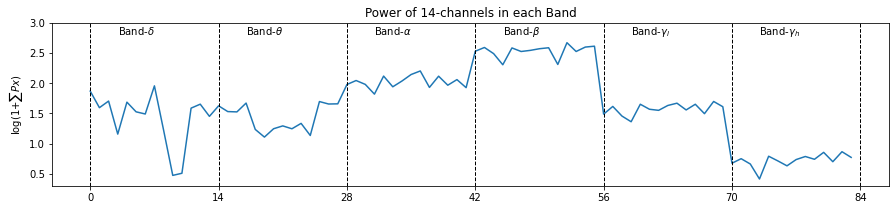

In [98]:
plt.figure(figsize=(15,3))
plt.plot(np.arange(X_train[0].shape[0]),X_train[0],label='')
plt.ylim([None, 3])
_ = [plt.axvline(i,ls='--',color='k',lw=1) for i in range(0,6*14+2,14)]

_ = [plt.text(i*14+3,2.8,f'Band-{fband_names[i]}') for i in range(6)]

plt.title('Power of 14-channels in each Band')
plt.xticks(range(0,6*14+1,14))
plt.ylabel(r'log(1+$\sum{Px}$)')
plt.show()

### No-flattening - 2D-Tensor

In [99]:
X_train,y_train,X_test,y_test = Subj.getXy_eeg(task=3,redo=True,normalize=False, log10p1=True,
                               flat=False, filter_order=5, filter_method='SOS', method='welch', window='hann',
                               scaling='density', detrend='constant', period_average='mean',
                               fBands=[], Sum=True, Mean=False, SD=False,verbose=0,
                               useRaw=False,redo_warn=True,use_v0=False)
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 6, 14) (100,) (44, 6, 14) (44,)


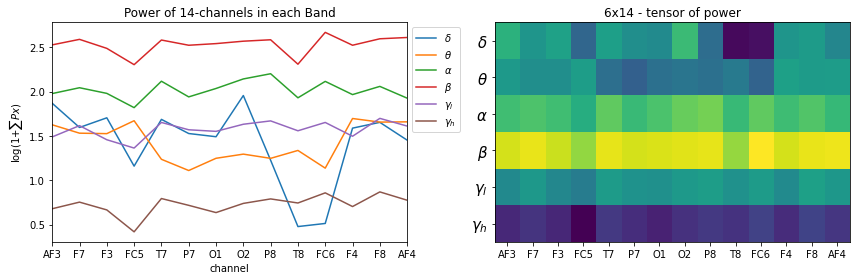

In [100]:
plt.figure(figsize=(12,4))
plt.subplot(121)
_ = [plt.plot(X_train[0][i],label=f'{fband_names[i]}') for i in range(6)]

plt.xticks(np.arange(14),ch_names)
plt.xlabel('channel')
plt.title('Power of 14-channels in each Band')
plt.ylabel(r'log(1+$\sum{Px}$)')
plt.legend(bbox_to_anchor=(1,1))
plt.xlim([0,13])

plt.subplot(122)
plt.imshow(X_train[0], aspect='auto')

plt.title('6x14 - tensor of power')
plt.xticks(np.arange(14),ch_names)
#plt.yticks(np.arange(6),[f'band-{i+1}' for i in range(6)])
plt.yticks(np.arange(6),fband_names,fontsize=15)

plt.tight_layout()
plt.show()

### No log10+1

* **log10+1 is a way to have stable and meaning ful values, if +1 is not used, any value below 1 will be very high in magnitude towards negative**
* **y = log(x+1) before log make sure, if x=0 --> y=0**

In [101]:
X_train,y_train,X_test,y_test = Subj.getXy_eeg(task=3,redo=True,normalize=False, log10p1=False,
                               flat=False, filter_order=5, filter_method='SOS', method='welch', window='hann',
                               scaling='density', detrend='constant', period_average='mean',
                               fBands=[], Sum=True, Mean=False, SD=False,verbose=0,
                               useRaw=False,redo_warn=True,use_v0=False)
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 6, 14) (100,) (44, 6, 14) (44,)


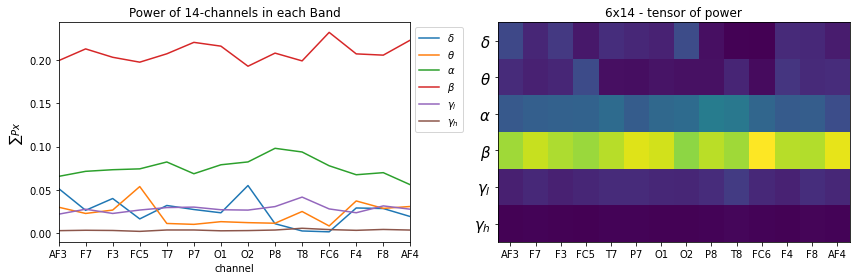

In [105]:
plt.figure(figsize=(12,4))
plt.subplot(121)
_ = [plt.plot(X_train[0][i],label=f'{fband_names[i]}') for i in range(6)]

plt.xticks(np.arange(14),ch_names)
plt.xlabel('channel')
plt.title('Power of 14-channels in each Band')
plt.ylabel(r'$\sum{Px}$')
plt.legend(bbox_to_anchor=(1,1))
plt.xlim([0,13])
plt.xticks(np.arange(14),ch_names)

plt.subplot(122)
plt.imshow(X_train[0], aspect='auto')

plt.title('6x14 - tensor of power')
plt.xticks(np.arange(14),ch_names)
#plt.yticks(np.arange(6),[f'band-{i+1}' for i in range(6)])
plt.yticks(np.arange(6),fband_names,fontsize=15)

plt.tight_layout()
plt.show()

### Spatial normalization (For each band normalize over channels)

* **The idea is to see which part of brain is more active relative to other parts in a given frequency band**
* **This will loose the relative differences between groups**

In [106]:
X_train,y_train,X_test,y_test = Subj.getXy_eeg(task=3,redo=True,normalize=True, log10p1=True,
                               flat=False, filter_order=5, filter_method='SOS', method='welch', window='hann',
                               scaling='density', detrend='constant', period_average='mean',
                               fBands=[], Sum=True, Mean=False, SD=False,verbose=0,
                               useRaw=False,redo_warn=True,use_v0=False)
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 6, 14) (100,) (44, 6, 14) (44,)


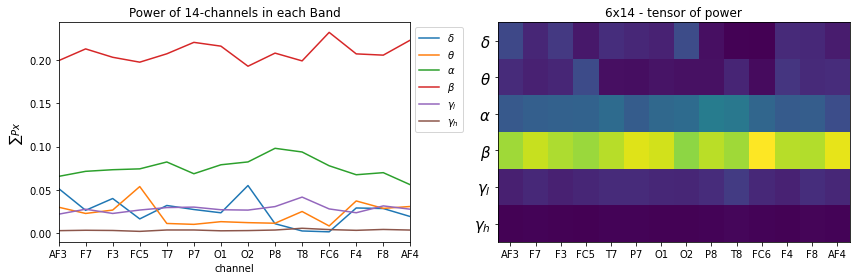

In [107]:
plt.figure(figsize=(12,4))
plt.subplot(121)
_ = [plt.plot(X_train[0][i],label=f'{fband_names[i]}') for i in range(6)]

plt.xlabel('channel')
plt.title('Power of 14-channels in each Band')
plt.ylabel(r'$\sum{Px}$')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(14),ch_names)
plt.xlim([0,13])

plt.subplot(122)
plt.imshow(X_train[0], aspect='auto')

plt.title('6x14 - tensor of power')
plt.xticks(np.arange(14),ch_names)
plt.yticks(np.arange(6),fband_names,fontsize=15)

plt.tight_layout()
plt.show()

## Custom Frequency Bands 

In [113]:
fBands      = [[None,8],[8,24],[24,32]]
fband3_names= [r'$\delta$+$\theta$',r'$\alpha$',r'$\beta$']

# for low-pass [None, fc] and for high pass [fc,None] is used

In [110]:
X_train,y_train,X_test,y_test = Subj.getXy_eeg(task=3,redo=True,normalize=False, log10p1=True,
                               flat=False, filter_order=5, filter_method='SOS', method='welch', window='hann',
                               scaling='density', detrend='constant', period_average='mean',
                               fBands=fBands, Sum=True, Mean=False, SD=False,verbose=0,
                               useRaw=False,redo_warn=True,use_v0=False)
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 3, 14) (100,) (44, 3, 14) (44,)


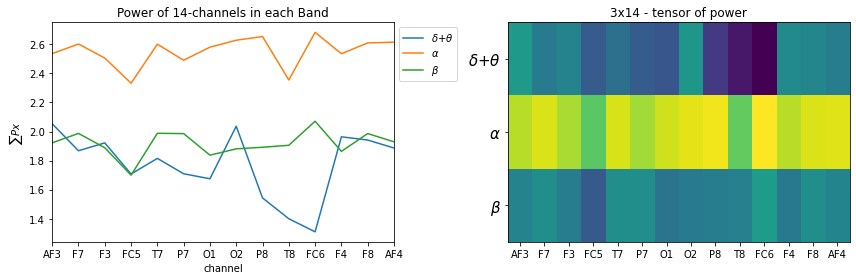

In [115]:
plt.figure(figsize=(12,4))
plt.subplot(121)
_ = [plt.plot(X_train[0][i],label=f'{fband3_names[i]}') for i in range(len(fband3_names))]

plt.xlabel('channel')
plt.title('Power of 14-channels in each Band')
plt.ylabel(r'$\sum{Px}$')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(14),ch_names)
plt.xlim([0,13])

plt.subplot(122)
plt.imshow(X_train[0], aspect='auto')

plt.title('3x14 - tensor of power')
plt.xticks(np.arange(14),ch_names)
plt.yticks(np.arange(len(fband3_names)),fband3_names,fontsize=15)

plt.tight_layout()
plt.show()

## More than Sum of Power

* **While computing power in each, we compute total power, however, sometimes, it is in interest to know the variation of power in given band**
* **It is uniformly distribuate or very peak**
* **So we compoute SD and Mean (Mean will be almost same as total power, since all of them will be divided by same number)**

In [116]:
X_train,y_train,X_test,y_test = Subj.getXy_eeg(task=3,redo=True,normalize=False, log10p1=True,
                               flat=False, filter_order=5, filter_method='SOS', method='welch', window='hann',
                               scaling='density', detrend='constant', period_average='mean',
                               fBands=fBands, Sum=True, Mean=True, SD=True,verbose=0,
                               useRaw=False,redo_warn=True,use_v0=False)
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
100%|##################################################|100\100|Sg - 0|    
100%|##################################################|44\44|Sg - 0|    
DataShape:  (100, 3, 3, 14) (100,) (44, 3, 3, 14) (44,)


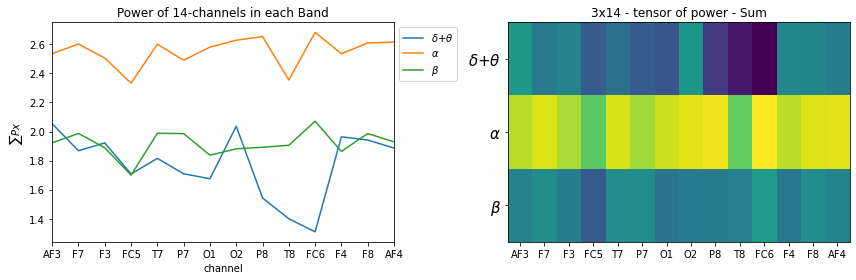

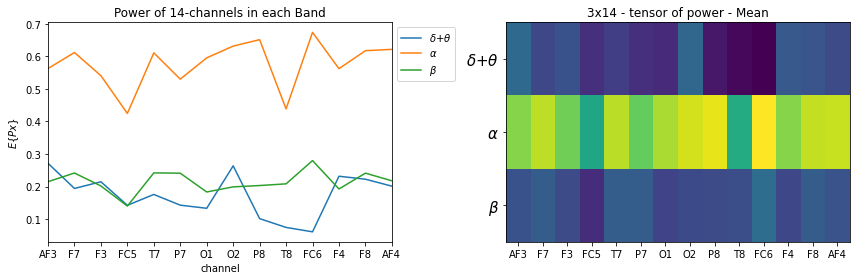

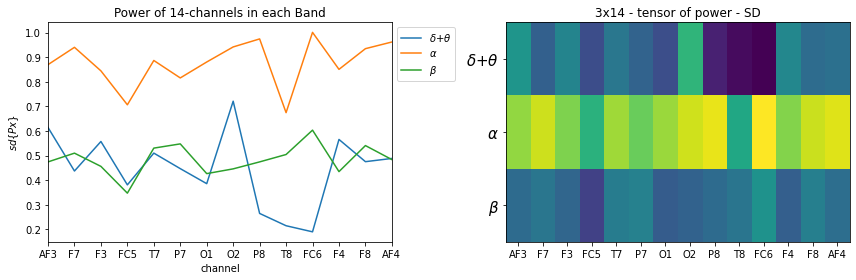

In [119]:
STS = ['Sum', 'Mean','SD']
for k, st in enumerate(STS):
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    _ = [plt.plot(X_train[0][k][i],label=f'{fband3_names[i]}') for i in range(len(fband3_names))]

    plt.xlabel('channel')
    plt.title('Power of 14-channels in each Band')
    if k==0: plt.ylabel(r'$\sum{Px}$')
    if k==1: plt.ylabel(r'$E\{Px\}$')
    if k==2: plt.ylabel(r'$sd\{Px\}$')
    plt.legend(bbox_to_anchor=(1,1))
    plt.xticks(np.arange(14),ch_names)
    plt.xlim([0,13])

    plt.subplot(122)
    plt.imshow(X_train[0][k], aspect='auto')

    plt.title(f'3x14 - tensor of power - {st}')
    plt.xticks(np.arange(14),ch_names)
    plt.yticks(np.arange(len(fband3_names)),fband3_names,fontsize=15)

    plt.tight_layout()
    plt.show()

## Documentation

In [9]:
## Feature Extraction - Rhythmic Features
help(Subj.getXy_eeg)

Help on method getXy_eeg in module phyaat.ProcessingLib:

getXy_eeg(task=1, features='rhythmic', eSample=[0, 0], redo=False, split='serial', splitAt=100, normalize=False, log10p1=True, flat=True, filter_order=5, filter_method='lfilter', method='welch', window='hann', scaling='density', detrend='constant', period_average='mean', winsize=-1, hopesize=None, fs=128, fBands=[], Sum=True, Mean=False, SD=False, use_joblib=False, n_jobs=-1, verbose=0, use_v0=True, useRaw=False, include_win_ind=False, redo_warn=True) method of phyaat.ProcessingLib.Subject instance
    task    :: int: {1,2,3,4,-1}, if task=-1, it will return label for all tasks e.g. y-shape=(n,4), each column for each task
        task=1 : Attention Level Prediction
        task=2 : Noise Level Prediction
        task=3 : Semanticity Prediction
        task=4 : LWR classification
        task=-1: All four
    
    features:: str: 'rhythmic', ['wavelet', 'spectorgram', .. ] not implemented yet
             : 'rhythmic', returns p